## Train a cellpose 2D model 

This notebook trains a cellpose 2d model to find the bees as suggested by Olivier Burri on [this imagesc question](https://forum.image.sc/t/how-to-count-bees-pattern-recognition-and-segmentation/90115)

Images for this example can be found [here](https://www.dropbox.com/scl/fo/joc3l8p0d3ewhn7rx202y/h?rlkey=hc4kgy1gv2xpq4udcm11mjwm0&dl=0)

Before running this notebook a set of patches must exist in the following format.

1.  Ground Truth are put in a directory called ```/ground truth0```
2.  Inputs are put in a directory called ```inputn``` where n is an integer 0...m and represents the channel.  Note:  RGB images may only have one 'channel' directory.
3.  In each of the both directories there exist a set of files of the same names.  For example if in the ```inputn``` directory we have ```apples0```, ```apples1```, ```apples2``` label images of the same name must exist in the ```ground truth``` directory.  

In [51]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from cellpose import models, io
from pathlib import Path

## Check what devices we have access to....

It's sometimes not as important to have a beefy GPU for 2D as it is for 3D, but let's check.  (depending on the number of training patch size, channels and number of rays we use we may need a good GPU)

In [52]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [53]:
parent_path=r'D:\images\tnia-python-images\imagesc\2023_12_20_segmenting_bees'
parent_path=r'/home/bnorthan/images/tnia-python-images/imagesc/2023_12_20_segmenting_bees'

train_path = os.path.join(parent_path, 'labels')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'model')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Use a helper to collect the training data

The helper will also normalize the inputs.

In [54]:
from tnia.deeplearning.dl_helper import collect_training_data
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, add_trivial_channel=False)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

Number of input images 26
Number of ground truth images  26
Size of first input image (256, 256, 3)
Size of first ground truth image  (256, 256)


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(256, 256, 3) (256, 256)
-0.03626943 1.1606218
2024-01-02 14:20:20,463 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


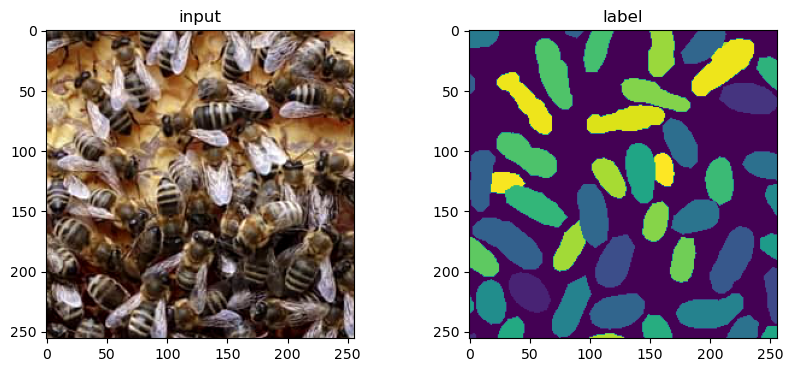

In [55]:

print(X[0].shape, Y[0].shape)
print(X[0].min(), X[0].max())
fig=imshow_multi2d([X[2], Y[2]], ['input', 'label'], 1,2)

## Divide into training and validation sets

Unlike stardist Cellpose does not seem to need numpy arrays as input.  So to create training and validation sets we can simply split the X and Y vectors. 

In [56]:

X_ = X.copy()
Y_ = Y.copy()

X_train = X_[:int(len(X_)*0.8)]
Y_train = Y_[:int(len(Y_)*0.8)]
X_test = X_[int(len(X_)*0.8):]
Y_test = Y_[int(len(Y_)*0.8):]

print('Number of images', len(X_))
print('Number of training images', len(X_train))
print('Number of test images ', len(X_test))



Number of images 26
Number of training images 20
Number of test images  6


## Create a cellpose model

In [48]:
os.path.join(model_path,'cellpose_thirdtry')

'/home/bnorthan/images/tnia-python-images/imagesc/2023_12_20_segmenting_bees/model/cellpose_thirdtry'

In [49]:
import os

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=True, model_type=None, pretrained_model=os.path.join(model_path,'models','cellpose_thirdtry'))

2024-01-02 12:49:36,448 [INFO] WRITING LOG OUTPUT TO /home/bnorthan/.cellpose/run.log
2024-01-02 12:49:36,448 [INFO] 
cellpose version: 	2.2.3 
platform:       	linux 
python version: 	3.9.16 
torch version:  	2.0.1+cu117
2024-01-02 12:49:36,449 [INFO] >>>> loading model /home/bnorthan/images/tnia-python-images/imagesc/2023_12_20_segmenting_bees/model/models/cellpose_thirdtry
2024-01-02 12:49:36,465 [INFO] ** TORCH CUDA version installed and working. **
2024-01-02 12:49:36,465 [INFO] >>>> using GPU
2024-01-02 12:49:36,527 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-01-02 12:49:36,527 [INFO] >>>> model diam_labels =  30.670 (mean diameter of training ROIs)


# Train the model

In [39]:
model_path

'/home/bnorthan/images/tnia-python-images/imagesc/2023_12_20_segmenting_bees/model'

In [42]:

new_model_path = model.train(X_train, Y_train, 
                              #test_data=X_val,
                              #test_labels=Y_val,
                              channels=[0,1], 
                              save_path=model_path, 
                              n_epochs=200,
                              #learning_rate=learning_rate, 
                              #weight_decay=weight_decay, 
                              nimg_per_epoch=200,
                              model_name='cellpose_thirdtry')

2024-01-02 12:05:20,711 [INFO] computing flows for labels


 20%|██        | 4/20 [00:00<00:00, 37.44it/s]

2024-01-02 12:05:20,822 [WARNING] empty masks!
2024-01-02 12:05:20,823 [WARNING] empty masks!


 65%|██████▌   | 13/20 [00:00<00:00, 64.36it/s]

2024-01-02 12:05:20,930 [WARNING] empty masks!


100%|██████████| 20/20 [00:00<00:00, 57.82it/s]

2024-01-02 12:05:21,066 [WARNING] 4 train images with number of masks less than min_train_masks (5), removing from train set
2024-01-02 12:05:21,076 [INFO] >>>> median diameter set to = 30
2024-01-02 12:05:21,077 [INFO] >>>> mean of training label mask diameters (saved to model) 30.670
2024-01-02 12:05:21,078 [INFO] >>>> training network with 2 channel input <<<<
2024-01-02 12:05:21,079 [INFO] >>>> LR: 0.20000, batch_size: 8, weight_decay: 0.00001
2024-01-02 12:05:21,079 [INFO] >>>> ntrain = 16
2024-01-02 12:05:21,080 [INFO] >>>> nimg_per_epoch = 200


2024-01-02 12:05:25,970 [INFO] Epoch 0, Time  4.9s, Loss 0.3583, LR 0.0000
2024-01-02 12:05:30,831 [INFO] saving network parameters to /home/bnorthan/images/tnia-python-images/imagesc/2023_12_20_segmenting_bees/model/models/cellpose_thirdtry
2024-01-02 12:05:50,373 [INFO] Epoch 5, Time 29.3s, Loss 0.3415, LR 0.1111
2024-01-02 12:06:14,842 [INFO] Epoch 10, Time 53.8s, Loss 0.3188, LR 0.2000
2024-01-02 12:07:03,938 [INFO] Epoch 20, Time 102.9s, Loss 0.2824, LR 0.2000
2024-01-02 12:07:53,103 [INFO] Epoch 30, Time 152.0s, Loss 0.2650, LR 0.2000
2024-01-02 12:08:42,359 [INFO] Epoch 40, Time 201.3s, Loss 0.2381, LR 0.2000
2024-01-02 12:09:31,641 [INFO] Epoch 50, Time 250.6s, Loss 0.2110, LR 0.2000
2024-01-02 12:10:20,944 [INFO] Epoch 60, Time 299.9s, Loss 0.1946, LR 0.2000
2024-01-02 12:11:09,973 [INFO] Epoch 70, Time 348.9s, Loss 0.1860, LR 0.2000
2024-01-02 12:11:58,883 [INFO] Epoch 80, Time 397.8s, Loss 0.1719, LR 0.2000
2024-01-02 12:12:48,147 [INFO] Epoch 90, Time 447.1s, Loss 0.1629, L

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

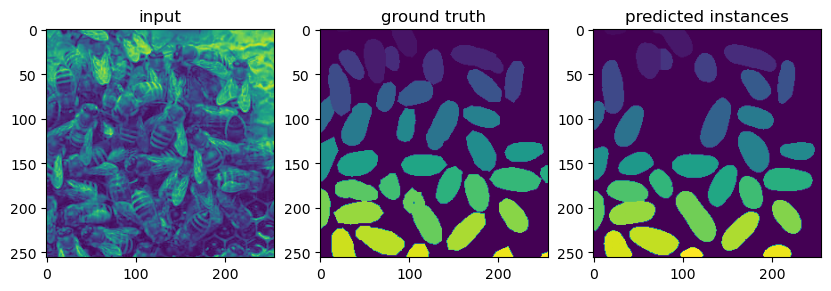

In [50]:

# run model on test images
masks = model.eval(X_train[0][0,:,:], channels=[0, 1,2],diameter=50)[0]
fig = imshow_multi2d([X_train[0][0,:,:], Y[0], masks],['input','ground truth','predicted instances'],1,3)


2024-01-02 12:46:48,315 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


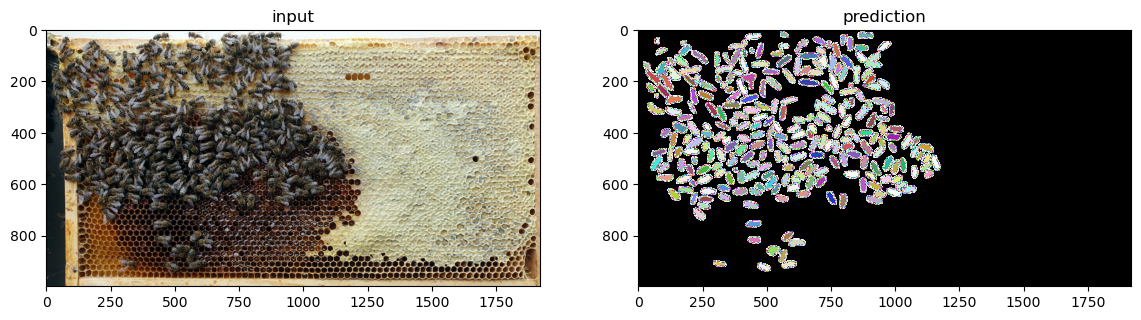

In [44]:
from skimage.io import imread
from tnia.plotting.plt_helper import random_label_cmap
from tnia.deeplearning.dl_helper import ray4_to_ellipsoid2d_labels
from csbdeep.utils import normalize

testim = imread(parent_path + r'/bsp1-2.jpg')
testim = normalize(testim,1,99.8, axis=(0,1))
labels = model.eval(testim, channels=[0, 1,2],diameter=50)[0]

fig = imshow_multi2d([testim,labels],['input','prediction'],1,2, width=14, height=8,colormaps=['gray', random_label_cmap()])


## View in Napari

In [45]:
import napari

viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels, name='labels')

<Labels layer 'labels' at 0x7fe93ffb69a0>

In [17]:
from skimage.io import imsave

label_name = parent_path + r'/labels_cycle3.tif'
imsave(label_name, labels.astype('uint16'))

264163233.py (4): D:\images\tnia-python-images\forum\bees/labels_cycle3.tif is a low contrast image
